# 03: 密度ベース & 確率的クラスタリング

このノートブックでは、これまでのK-meansや階層的クラスタリングとは異なる発想に基づく、2つの高度なクラスタリング手法について学びます。
一つは、データの「密度」に着目して任意の形状のクラスタを発見できる**DBSCAN**。もう一つは、各データが複数のクラスタに所属する確率をモデル化する<b>混合ガウスモデル (GMM)</b>です。

これらの手法は、球状のクラスタを仮定するK-meansなどではうまく機能しない、より複雑なデータ構造を捉える能力を持っています。

**参考論文:**
*   (DBSCAN) Ester, M., Kriegel, H. P., Sander, J., & Xu, X. (1996). A density-based algorithm for discovering clusters in large spatial databases with noise. In *Proceedings of the Second International Conference on Knowledge Discovery and Data Mining (KDD-96)*.
*   (EM for GMM) Dempster, A. P., Laird, N. M., & Rubin, D. B. (1977). Maximum likelihood from incomplete data via the EM algorithm. *Journal of the Royal Statistical Society: Series B (Methodological)*, 39(1), 1-38.

**このノートブックで学ぶこと:**
1.  密度ベースクラスタリングの基本概念：コア点、到達可能性、ノイズ。
2.  DBSCANのアルゴリズムとそのNumPyによるスクラッチ実装。
3.  DBSCANが任意の形状のクラスタを発見し、ノイズを分離できる理由。
4.  確率的クラスタリングの考え方と混合ガウスモデル（GMM）。
5.  GMMのパラメータを推定するためのEM（Expectation-Maximization）アルゴリズムの理論。
6.  NumPyを用いたGMMのスクラッチ実装。

**前提知識:**
*   ユークリッド距離の計算。
*   確率・統計の基礎知識（特に正規分布、確率密度関数）。
*   NumPyによるベクトル・行列演算。
*   Matplotlibによるデータの可視化。

## 1. 必要なライブラリのインポート

In [124]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from scipy.stats import multivariate_normal

## 2. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCANは、**密接にパックされた点の領域**をクラスタとして定義する、密度ベースのクラスタリングアルゴリズムです。K-meansと異なり、クラスタの形状を球状と仮定せず、任意の形状のクラスタを発見できます。また、どのクラスタにも属さない**ノイズ点**を明示的に扱うことができるのも大きな特徴です。

### 2.1 DBSCANの基本概念

DBSCANを理解するには、3つの重要な概念を把握する必要があります。

1.  **コア点 (Core Point)**: ある点 $\boldsymbol{p}$ がコア点であるとは、その点の半径 $\epsilon$ (Eps) の近傍内に、自身を含めて `MinPts` 個以上の点が存在することを言います。つまり、その点の周りは「密」であるということです。

2.  **（直接）到達可能 (Directly Reachable)**: 点 $\boldsymbol{q}$ が点 $\boldsymbol{p}$ から直接到達可能であるとは、$\boldsymbol{p}$ がコア点であり、かつ $\boldsymbol{q}$ が $\boldsymbol{p}$ の $\epsilon$-近傍内に存在することを言います。

3.  **到達可能 (Reachable)**: 点 $\boldsymbol{q}$ が点 $\boldsymbol{p}$ から到達可能であるとは、$\boldsymbol{p}$ から $\boldsymbol{q}$ までの「直接到達可能」な点の連鎖（$\boldsymbol{p}_1, \boldsymbol{p}_2, \dots, \boldsymbol{p}_n$ で、$p_1=p, p_n=q$ かつ $p_{i+1}$ が $p_i$ から直接到達可能）が存在することを言います。

これらの概念に基づき、DBSCANはクラスタを「**互いに到達可能なコア点の集合**」として定義し、そのコア点から到達可能な非コア点（**境界点, Border Point**）も同じクラスタに含めます。どのコア点からも到達不可能な点は<b>ノイズ (Noise)</b>と見なされます。

### 2.2 DBSCANのアルゴリズム

1.  **初期化**: 全ての点を「未訪問」とする。
2.  **反復**: データセットからランダムに未訪問の点 $\boldsymbol{p}$ を選ぶ。
3.  **近傍探索**: $\boldsymbol{p}$ の $\epsilon$-近傍内の点の数を数える。
4.  **判定**:  
    a.  もし近傍内の点の数が `MinPts` 未満なら、$\boldsymbol{p}$ を一時的にノイズとマークする（後でどこかのクラスタの境界点になる可能性もある）。  
    b.  もし近傍内の点の数が `MinPts` 以上なら、$\boldsymbol{p}$ をコア点とみなし、新しいクラスタを生成する。  
        i.  $\boldsymbol{p}$ と、その $\epsilon$-近傍内の全ての点を同じクラスタに割り当てる。  
        ii. 近傍内の点について再帰的にステップ3, 4を繰り返し、到達可能な点を全て同じクラスタに含めていく（クラスタを拡張する）。  
5.  全ての点が訪問済みになるまでステップ2-4を繰り返す。

### 2.3 DBSCANのスクラッチ実装

#### 2.3.1 データの準備

DBSCANの性能を見るために、K-meansではうまく分離できない三日月型のデータを生成します。

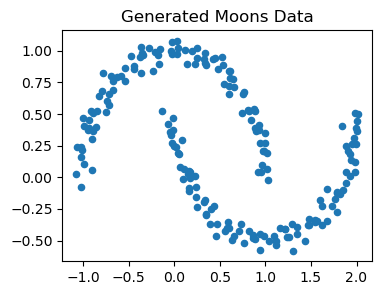

In [125]:
# 三日月型のデータを生成
X, y_true = make_moons(n_samples=200, noise=0.05, random_state=0)

# データをプロット
plt.figure(figsize=(4, 3))
plt.scatter(X[:, 0], X[:, 1], s=20)
plt.title("Generated Moons Data")
plt.show()

#### 2.3.2 DBSCANクラスの実装

In [126]:
class DBSCAN:
    def __init__(self, eps=0.3, min_pts=5):
        self.eps = eps
        self.min_pts = min_pts
        self.labels_ = None

    def _region_query(self, x, point_idx):
        '''指定された点の近傍の点のインデックスを返す'''
        distances = np.linalg.norm(x - x[point_idx], axis=1)
        return np.where(distances < self.eps)[0]
    
    def fit_predict(self, x):
        '''DBSCANアルゴリズムを適用してクラスタリングを行う'''
        n_samples = x.shape[0]
        # -1: 未分類， 0: ノイズ， 1以上: クラスタ番号
        self.labels_ = np.full(n_samples, -1)
        cluster_id = 0

        for i in range(n_samples):
            if self.labels_[i] != -1: # すでに分類されている点はスキップ
                continue
            
            # i番目の点の近傍を取得
            neighbors = self._region_query(x, i)

            if len(neighbors) < self.min_pts:
                # コア点ではない -> ノイズとしてマーク
                self.labels_[i] = 0
                continue

            # コア点である -> 新しいクラスタを開始
            cluster_id += 1
            self.labels_[i] = cluster_id

            # クラスタの拡張
            seed_set = set(neighbors)
            seed_set.remove(i)

            while seed_set:
                current_point_idx = seed_set.pop()

                # ノイズとマークされていた点をクラスタに追加
                if self.labels_[current_point_idx] == 0:
                    self.labels_[current_point_idx] = cluster_id

                # 未分類の点のみを処理
                if self.labels_[current_point_idx] != -1:
                    continue

                self.labels_[current_point_idx] = cluster_id

                # 新しい点の近傍を取得
                new_neighbors = self._region_query(x, current_point_idx)

                # もし新しい点がコア点ならば、クラスタを拡張
                if len(new_neighbors) >= self.min_pts:
                    seed_set.update(new_neighbors)

        return self.labels_

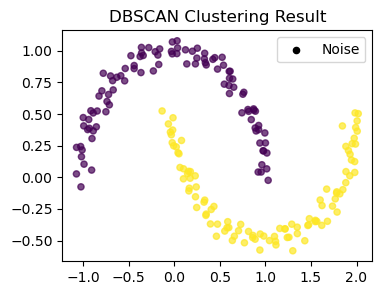

In [127]:
# DBSCANを実行
dbscan = DBSCAN(eps=0.3, min_pts=5)
labels = dbscan.fit_predict(X)

# 結果をプロット
plt.figure(figsize=(4, 3))
# ノイズ点は黒で表示
plt.scatter(X[labels == 0, 0], X[labels == 0, 1], c='black', s=20, label='Noise')
# クラスタ点は色分けして表示
plt.scatter(X[labels > 0, 0], X[labels > 0, 1], c=labels[labels > 0], s=20, cmap='viridis', alpha=0.7)
plt.title("DBSCAN Clustering Result")
plt.legend()
plt.show()

## 3. 混合ガウスモデル (Gaussian Mixture Model, GMM)

GMMは、データセットが**複数のガウス分布（正規分布）の混合**によって生成されたと仮定する、確率的クラスタリングモデルです。
各データポイントは、いずれか1つのクラスタに確定的に属するのではなく、「クラスタ1に属する確率が70%、クラスタ2に属する確率が30%」といったように、**ソフトな（確率的な）割り当て**を行います。

### 3.1 GMMの理論

GMMは以下のパラメータによって特徴づけられます。
*   **混合係数 (Mixing coefficients) $\pi_k$**: 各ガウス分布（クラスタ）が選ばれる事前確率。($\sum_{k=1}^K \pi_k = 1$)
*   **平均ベクトル (Mean vectors) $\boldsymbol{\mu}_k$**: 各ガウス分布の中心。
*   **共分散行列 (Covariance matrices) $\boldsymbol{\Sigma}_k$**: 各ガウス分布の形状と広がり。

あるデータポイント $\boldsymbol{x}$ が観測される確率密度は、これらの混合として表されます。
$$
p(\boldsymbol{x} | \pi, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum_{k=1}^{K} \pi_k \mathcal{N}(\boldsymbol{x} | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)
$$
ここで、$\mathcal{N}(\boldsymbol{x} | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$ は平均 $\boldsymbol{\mu}_k$、共分散 $\boldsymbol{\Sigma}_k$ の多変量正規分布の確率密度関数です。

GMMの学習の目的は、与えられたデータセット $X$ に対する**対数尤度 (Log-Likelihood)** を最大化するようなパラメータ $(\pi, \boldsymbol{\mu}, \boldsymbol{\Sigma})$ を見つけることです。
$$
\log p(X | \pi, \boldsymbol{\mu}, \boldsymbol{\Sigma}) = \sum_{i=1}^{N} \log \left( \sum_{k=1}^{K} \pi_k \mathcal{N}(\boldsymbol{x}_i | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) \right)
$$

### 3.2 EM (Expectation-Maximization) アルゴリズム

この対数尤度関数は、$\log$ の中に和の形が入っているため、直接最大化するのは困難です。そこで、**EMアルゴリズム**という反復的な手法が用いられます。
EMアルゴリズムは、各データポイントがどのガウス分布から生成されたかという「潜在変数」を導入し、以下の2つのステップを収束するまで繰り返します。

1.  **E-step (Expectation Step)**:
    現在のパラメータ $(\pi, \boldsymbol{\mu}, \boldsymbol{\Sigma})$ を用いて、各データポイント $\boldsymbol{x}_i$ が各クラスタ $k$ に属する<b>事後確率（負担率, responsibility）</b>を計算します。
    $$
    \gamma(z_{ik}) = p(z_k=1 | \boldsymbol{x}_i) = \frac{\pi_k \mathcal{N}(\boldsymbol{x}_i | \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}{\sum_{j=1}^{K} \pi_j \mathcal{N}(\boldsymbol{x}_i | \boldsymbol{\mu}_j, \boldsymbol{\Sigma}_j)}
    $$

2.  **M-step (Maximization Step)**:
    E-stepで計算した負担率 $\gamma(z_{ik})$ を用いて、パラメータを更新します。これは、各データポイントを負担率に応じてソフトに各クラスタに割り当て、尤度を最大化する操作に相当します。
    *   **有効なデータ数の更新**: $N_k = \sum_{i=1}^{N} \gamma(z_{ik})$
    *   **混合係数の更新**: $\pi_k^{new} = \frac{N_k}{N}$
    *   **平均ベクトルの更新**: $\boldsymbol{\mu}_k^{new} = \frac{1}{N_k} \sum_{i=1}^{N} \gamma(z_{ik}) \boldsymbol{x}_i$
    *   **共分散行列の更新**: $\boldsymbol{\Sigma}_k^{new} = \frac{1}{N_k} \sum_{i=1}^{N} \gamma(z_{ik}) (\boldsymbol{x}_i - \boldsymbol{\mu}_k^{new})(\boldsymbol{x}_i - \boldsymbol{\mu}_k^{new})^T$

このE-stepとM-stepを繰り返すことで、対数尤度は単調に増加し、局所最適解に収束することが保証されています。

### 3.3 GMMのスクラッチ実装

#### 3.3.1 データの準備

GMMは楕円形のクラスタも捉えられるため、少し形状の異なるクラスタを持つデータを生成します。

C:\Users\USER194\AppData\Local\Temp\ipykernel_21688\3862015603.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  cluster1 = np.random.multivariate_normal(mean1, cov1, 100)


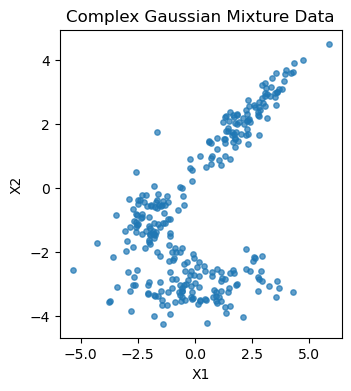

In [128]:
np.random.seed(42)

# 楕円形クラスタ1
mean1 = [2, 2]
cov1 = [[2, 1.5], [1.5, 1]]
cluster1 = np.random.multivariate_normal(mean1, cov1, 100)

# 円形クラスタ2
mean2 = [-2, -1]
cov2 = [[0.5, 0], [0, 0.5]]
cluster2 = np.random.multivariate_normal(mean2, cov2, 80)

# 細長い楕円形クラスタ3
mean3 = [0, -3]
cov3 = [[3, 0.1], [0.1, 0.3]]
cluster3 = np.random.multivariate_normal(mean3, cov3, 120)

X_complex = np.vstack([cluster1, cluster2, cluster3])

# 可視化
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.scatter(X_complex[:, 0], X_complex[:, 1], s=15, alpha=0.7)
plt.title("Complex Gaussian Mixture Data")
plt.xlabel("X1")
plt.ylabel("X2")
plt.show()

#### 3.3.2 GMMクラスの実装

In [129]:
class GMM:
    def __init__(self, n_components=3, max_iter=100, tol=1e-4, random_state=None):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol # 収束判定の閾値
        self.random_state = random_state
        # パラメータ
        self.pi_ = None
        self.means_ = None
        self.covariances_ = None
        self.labels_ = None
        self.log_likelihood_ = -np.inf

    def fit(self, x):
        if self.random_state is not None:
            np.random.seed(self.random_state)

        n_samples, n_features = x.shape

        # 初期化 (k-meansの結果を利用するのが一般的だが，ここではランダムに初期化)
        # 事後確率をランダムに初期化
        resp = np.random.rand(n_samples, self.n_components)
        resp /= resp.sum(axis=1, keepdims=True)

        for i in range(self.max_iter):
            # M-step: パラメータの更新
            nk = resp.sum(axis=0)
            self.pi_ = nk / n_samples
            self.means_ = np.dot(resp.T, x) / nk[:, np.newaxis]
            self.covariances_ = np.zeros((self.n_components, n_features, n_features))
            for k in range(self.n_components):
                diff = x - self.means_[k]
                self.covariances_[k] = np.dot(resp[:, k] * diff.T, diff) / nk[k]

            # E-step: 事後確率の更新
            likelihoods = np.zeros((n_samples, self.n_components))
            for k in range(self.n_components):
                likelihoods[:, k] = multivariate_normal(self.means_[k], self.covariances_[k]).pdf(x)

            weighted_likelihoods = likelihoods * self.pi_
            resp = weighted_likelihoods / weighted_likelihoods.sum(axis=1, keepdims=True)

            # 収束判定
            new_log_likelihoods = np.sum(np.log(weighted_likelihoods.sum(axis=1)))
            
            if abs(new_log_likelihoods - self.log_likelihood_) < self.tol:
                break

            self.log_likelihood_ = new_log_likelihoods

        return self
    
    def predict(self, x):
        likelihoods = np.zeros((x.shape[0], self.n_components))
        for k in range(self.n_components):
            likelihoods[:, k] = multivariate_normal(self.means_[k], self.covariances_[k]).pdf(x)

        weighted_likelihoods = likelihoods * self.pi_
        return np.argmax(weighted_likelihoods, axis=1)

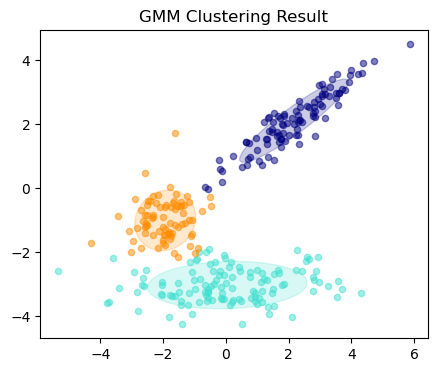

In [131]:
def plot_gmm_result(X, labels, means, covariances):
    plt.figure(figsize=(5, 4))
    colors = ['navy', 'turquoise', 'darkorange']
    for k, color in enumerate(colors):
        plt.scatter(X[labels == k, 0], X[labels == k, 1], s=20, alpha=0.5, color=color)

    # ガウス分布の等高線を描画
    for k, color in enumerate(colors):
        v, w = np.linalg.eigh(covariances[k])
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi
        # angleをキーワード引数として指定
        ell = plt.matplotlib.patches.Ellipse(means[k], v[0], v[1], angle=180. + angle, color=color)
        ell.set_clip_box(plt.gca().bbox)
        ell.set_alpha(0.2)
        plt.gca().add_artist(ell)
    
    plt.title("GMM Clustering Result")
    plt.show()

# GMMを実行
gmm = GMM(n_components=3, random_state=0)
gmm.fit(X_complex)
labels = gmm.predict(X_complex)

# 結果をプロット
plot_gmm_result(X_complex, labels, gmm.means_, gmm.covariances_)

## 4. まとめと考察

このノートブックでは、密度ベースのDBSCANと確率的モデルであるGMMについて学びました。

*   **DBSCAN**は、データの密度に基づいてクラスタを形成するため、**任意の形状のクラスタ**を発見できる強力な手法です。また、どのクラスタにも属さない**ノイズ点を明示的に分離**できるという大きな利点があります。ハイパーパラメータ（`eps`, `min_pts`）の設定が結果を大きく左右しますが、データのスケールや密度が分かっていれば非常に有効です。

*   **GMM**は、データが複数のガウス分布から生成されたと仮定し、EMアルゴリズムを用いてそのパラメータを推定します。各データポイントが各クラスタに属する<b>確率（負担率）</b>を計算するため、**ソフトクラスタリング**が可能です。クラスタが楕円形であると仮定できる場合に特に強力で、生成モデルとしての側面も持ちます。

**実践的なガイドライン:**

| 手法 | 主な用途 | 長所 | 短所 |
| :--- | :--- | :--- | :--- |
| **DBSCAN** | 任意形状のクラスタ発見、ノイズ除去、異常検知 | クラスタ形状に柔軟、ノイズに頑健、クラスタ数不要 | パラメータ設定が敏感、密度が異なるクラスタの扱が苦手 |
| **GMM** | ソフトクラスタリング、楕円形クラスタ、生成モデル | 確率的な所属をモデル化、クラスタ形状が柔軟 | 収束が局所解に陥りやすい、計算コストが高い |

これらの手法は、K-meansや階層的クラスタリングでは対応できない、より複雑なデータ構造を捉えるための重要なツールです。DBSCANはクラスタの形状に、GMMはクラスタの所属の曖昧さに、それぞれ異なる柔軟性を提供します。解きたい問題の性質に応じて、適切なクラスタリング手法を選択することが重要です。